# EXERCISE 5

The file  `ESE3_es5_dataset.csv` contains the values (in Celsius degrees) of the global temperature index measured since 1900 to 1997.

## Point 1
Identify the model for these data.

> ### Solution
> First, let's show the time series plot

In [22]:
#Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import statsmodels.api as sm

#Import the dataset
data = pd.read_csv('ESE3_es5_dataset.csv')

# Inspect the dataset
print(data.head())

    Ex5
0 -0.14
1 -0.20
2 -0.33
3 -0.46
4 -0.48


In [23]:
# Now add a 'year' column to the dataset with values from 1900 to 1997
data['year'] = np.arange(1900, 1998)
print(data.head())

    Ex5  year
0 -0.14  1900
1 -0.20  1901
2 -0.33  1902
3 -0.46  1903
4 -0.48  1904


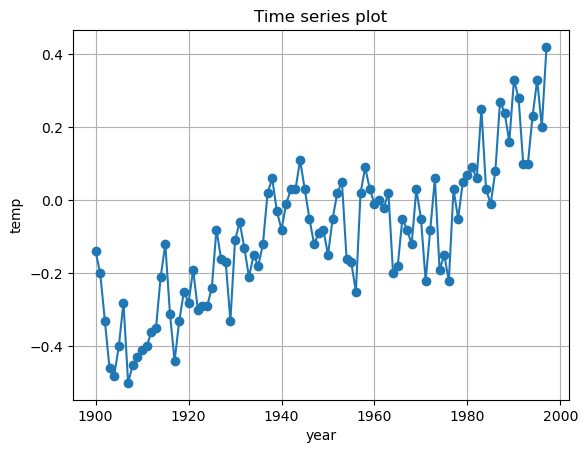

In [24]:
#Time series plot
plt.plot(data['year'], data['Ex5'], 'o-')
plt.title('Time series plot')
plt.xlabel('year')
plt.ylabel('temp')
plt.grid()
plt.show()


> There seems to be a trend in the process. Besides, autocorrelation may be present. Let's perform the runs test to check if data are random or not

In [25]:
# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(data['Ex5'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

if pval_runs<0.05:
    print('The null hypothesis is rejected: the process is not random')
else:
    print('The null hypothesis is accepted: the process is random')


Runs test p-value = 0.000
The null hypothesis is rejected: the process is not random


> Let's show ACF and PACF

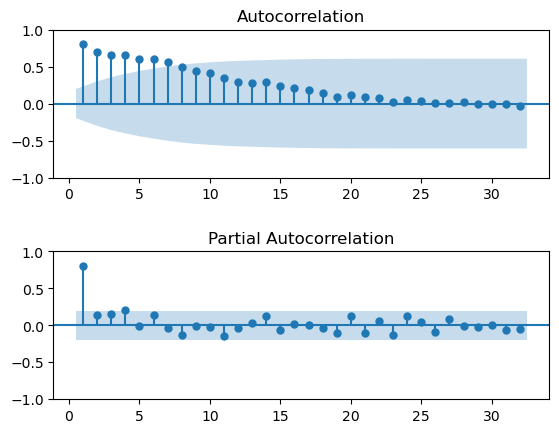

In [26]:
#ACF and PACF
# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(data['Ex5'], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(data['Ex5'], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

> The process looks highly autocorrelated too. Trend and AR(1) are possible regressors. Let's perform stepwise regression.


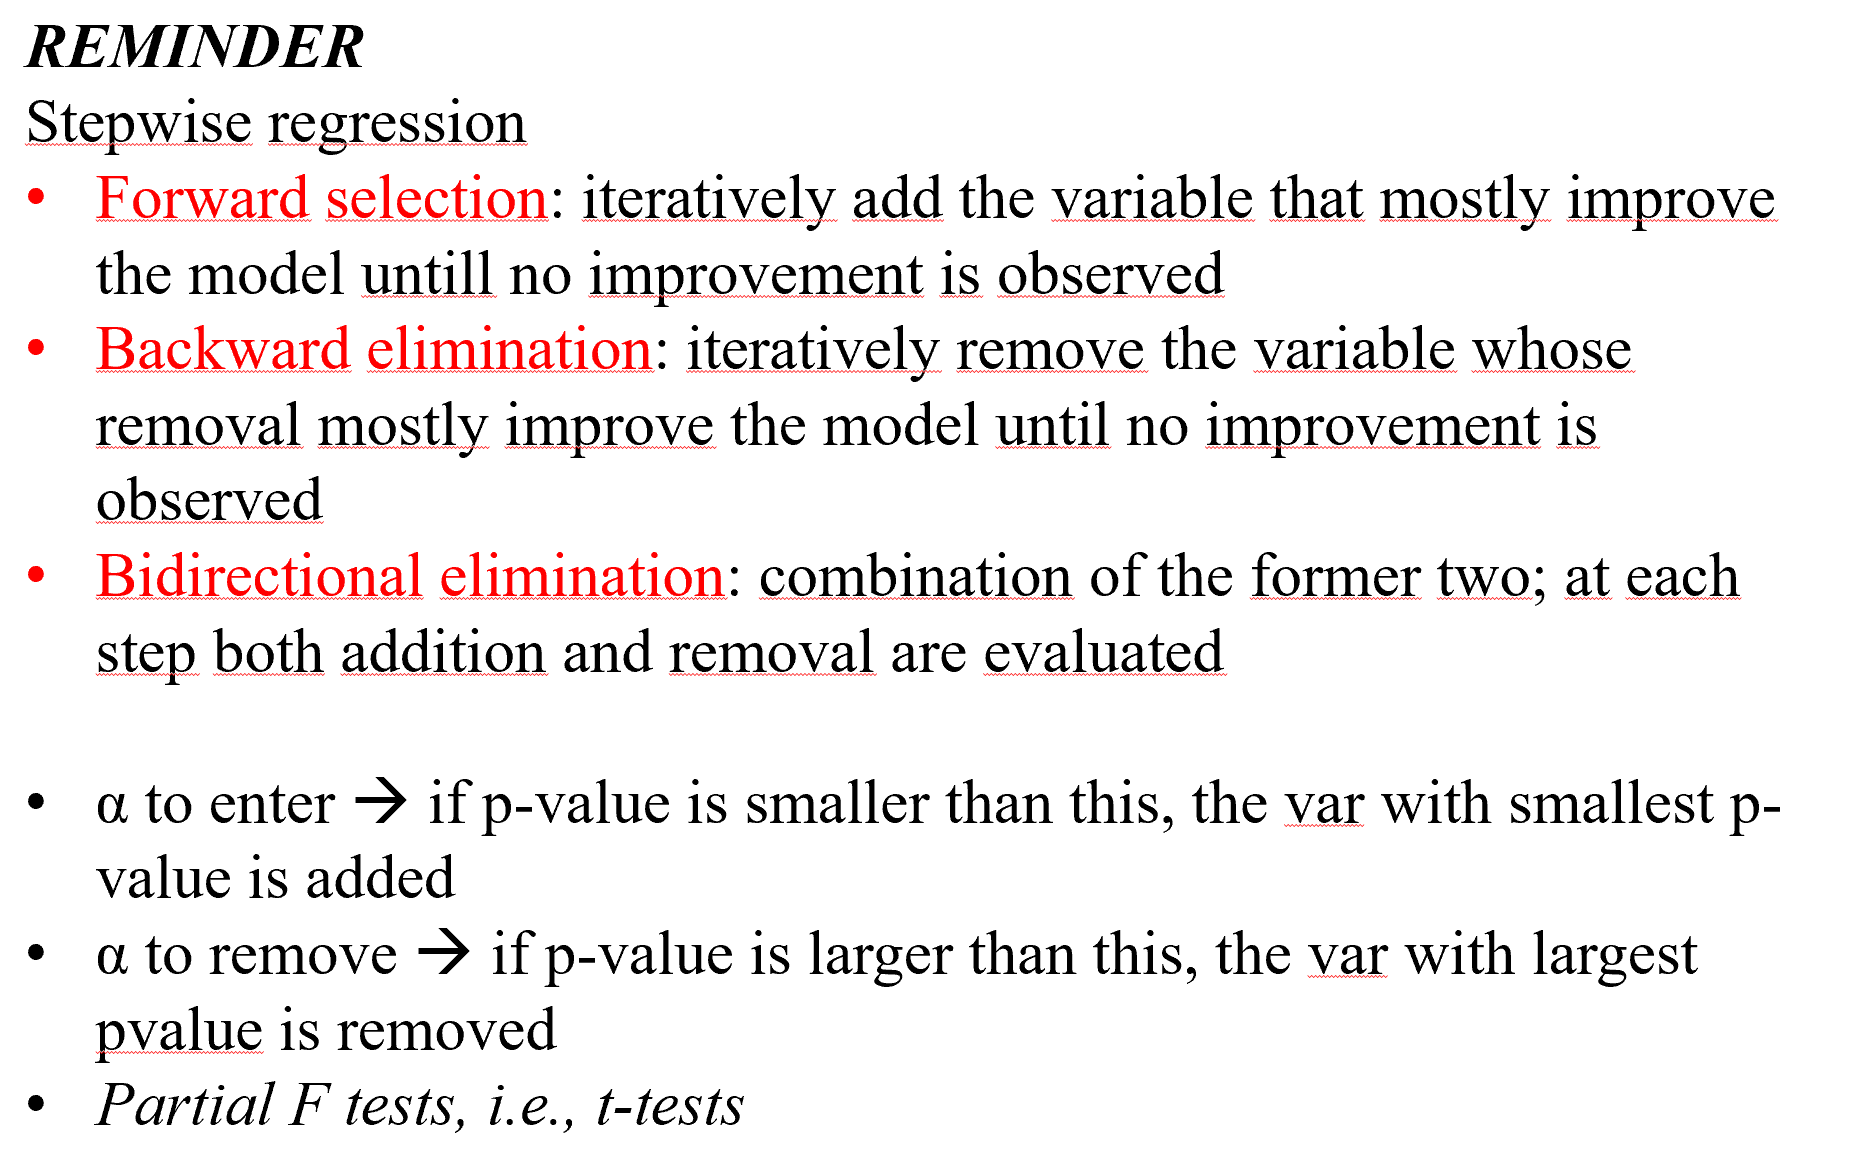
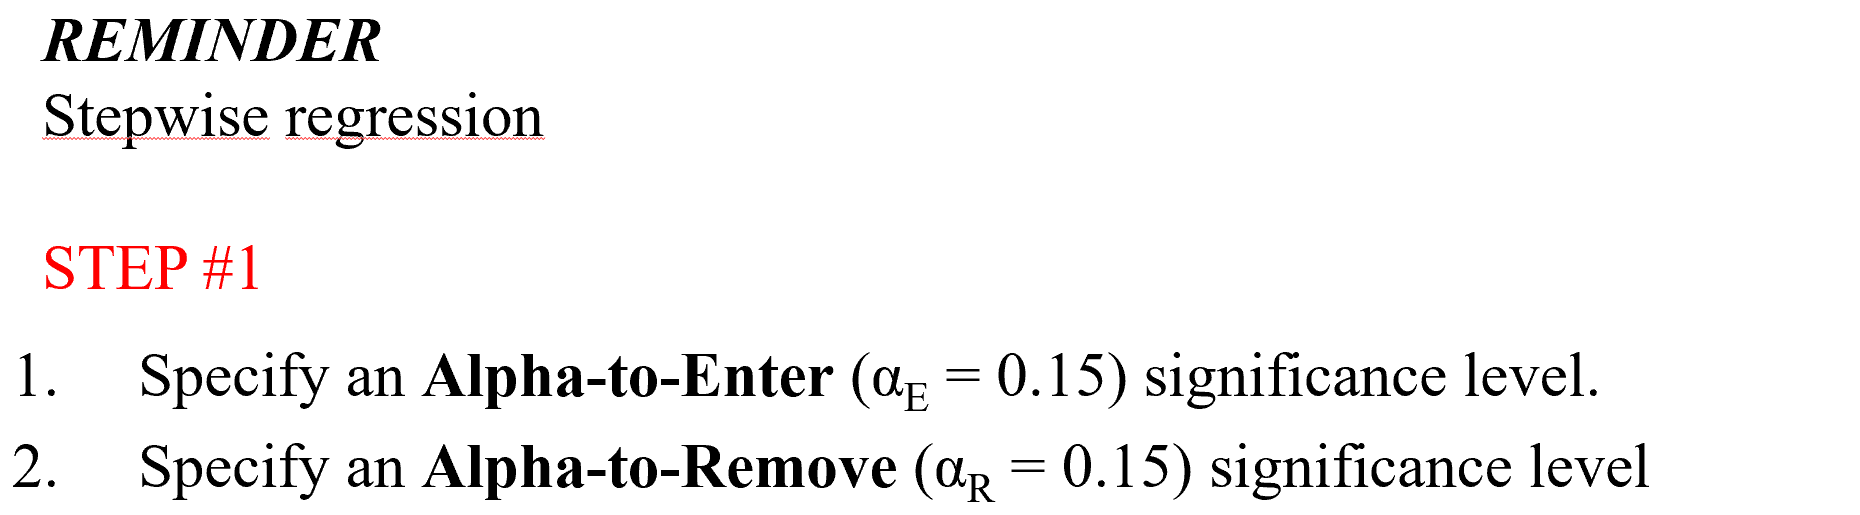
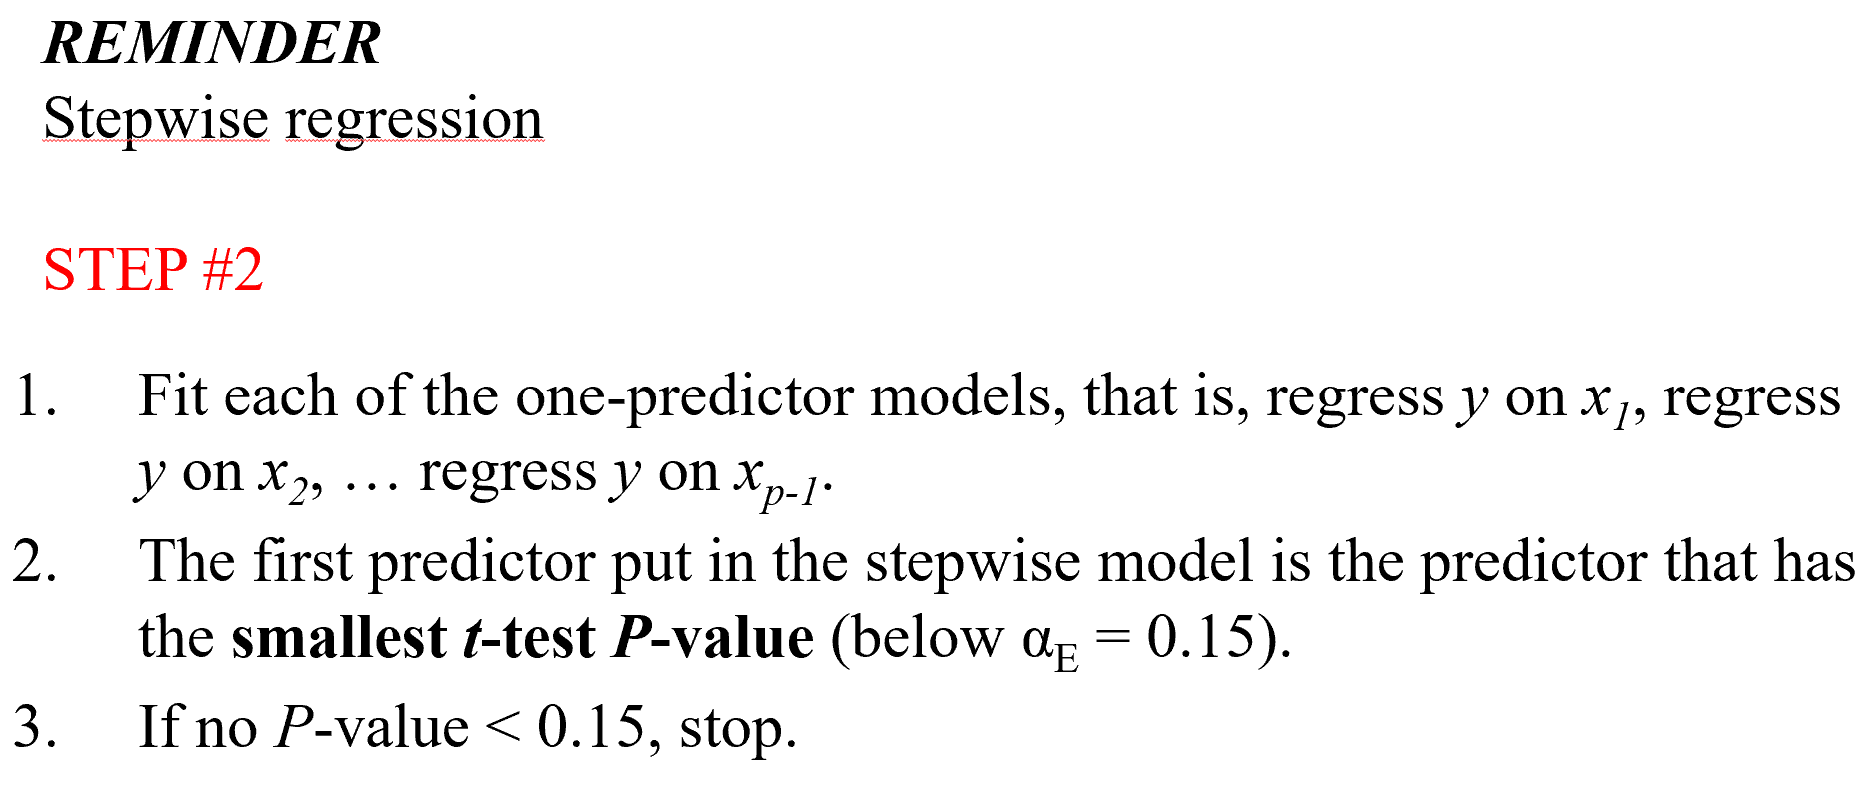
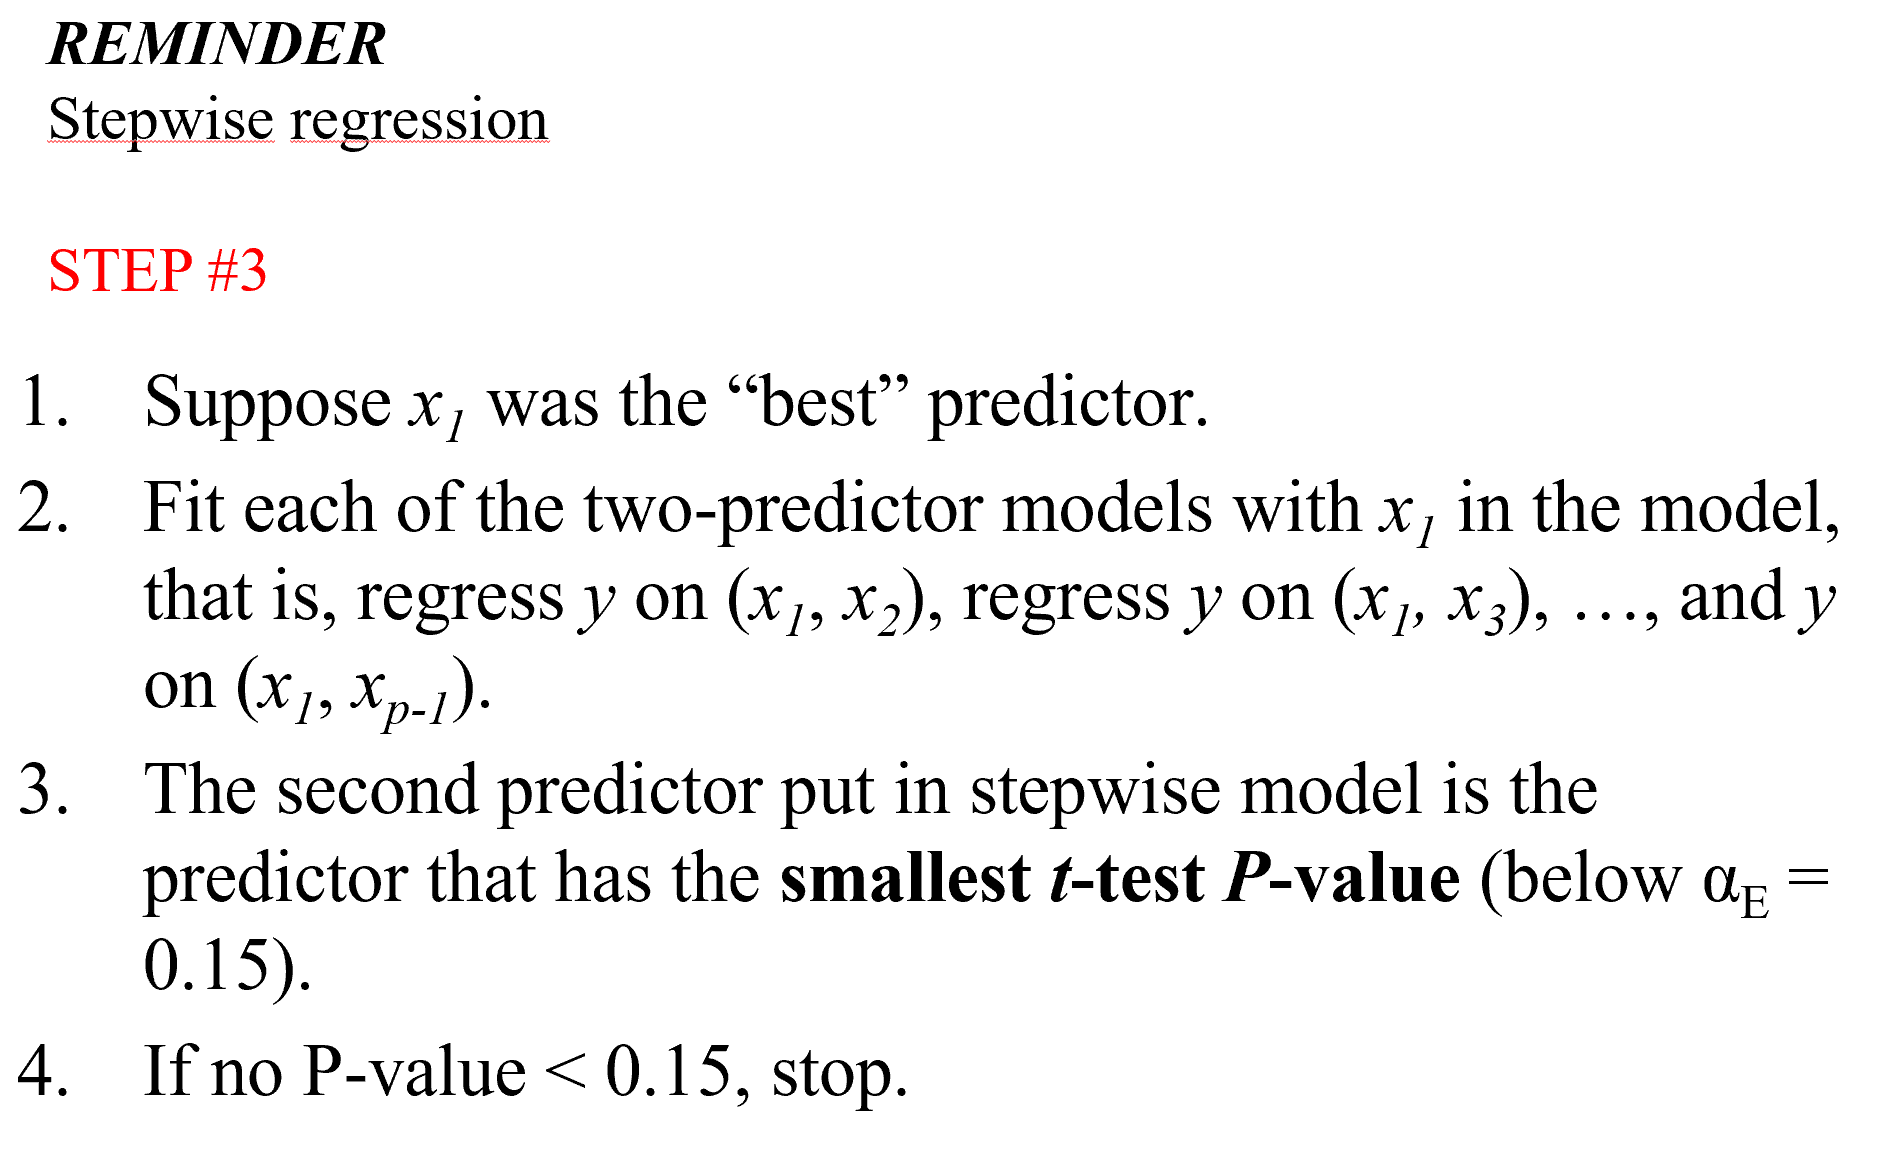
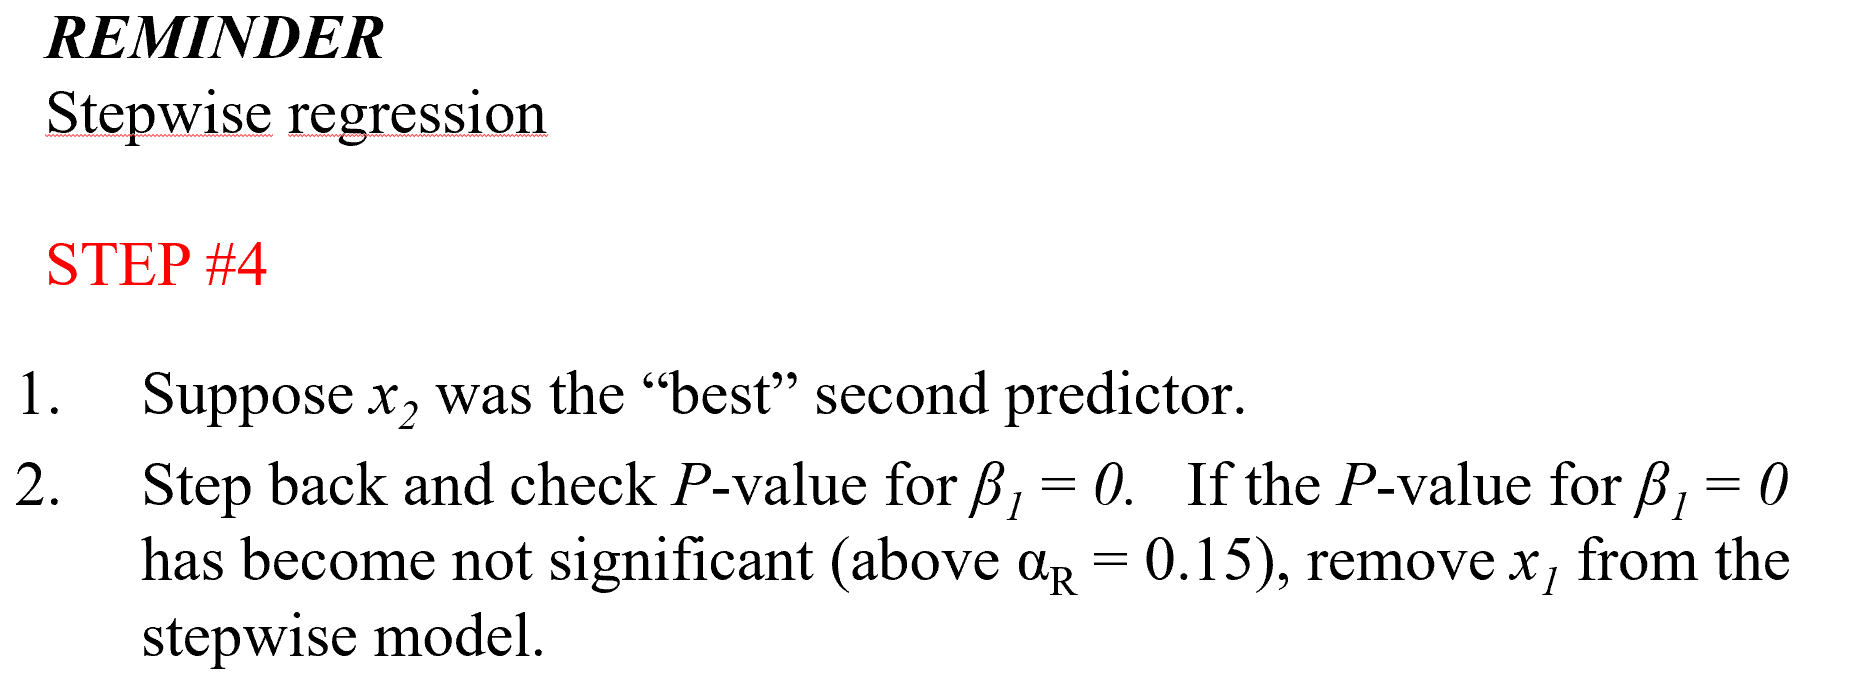
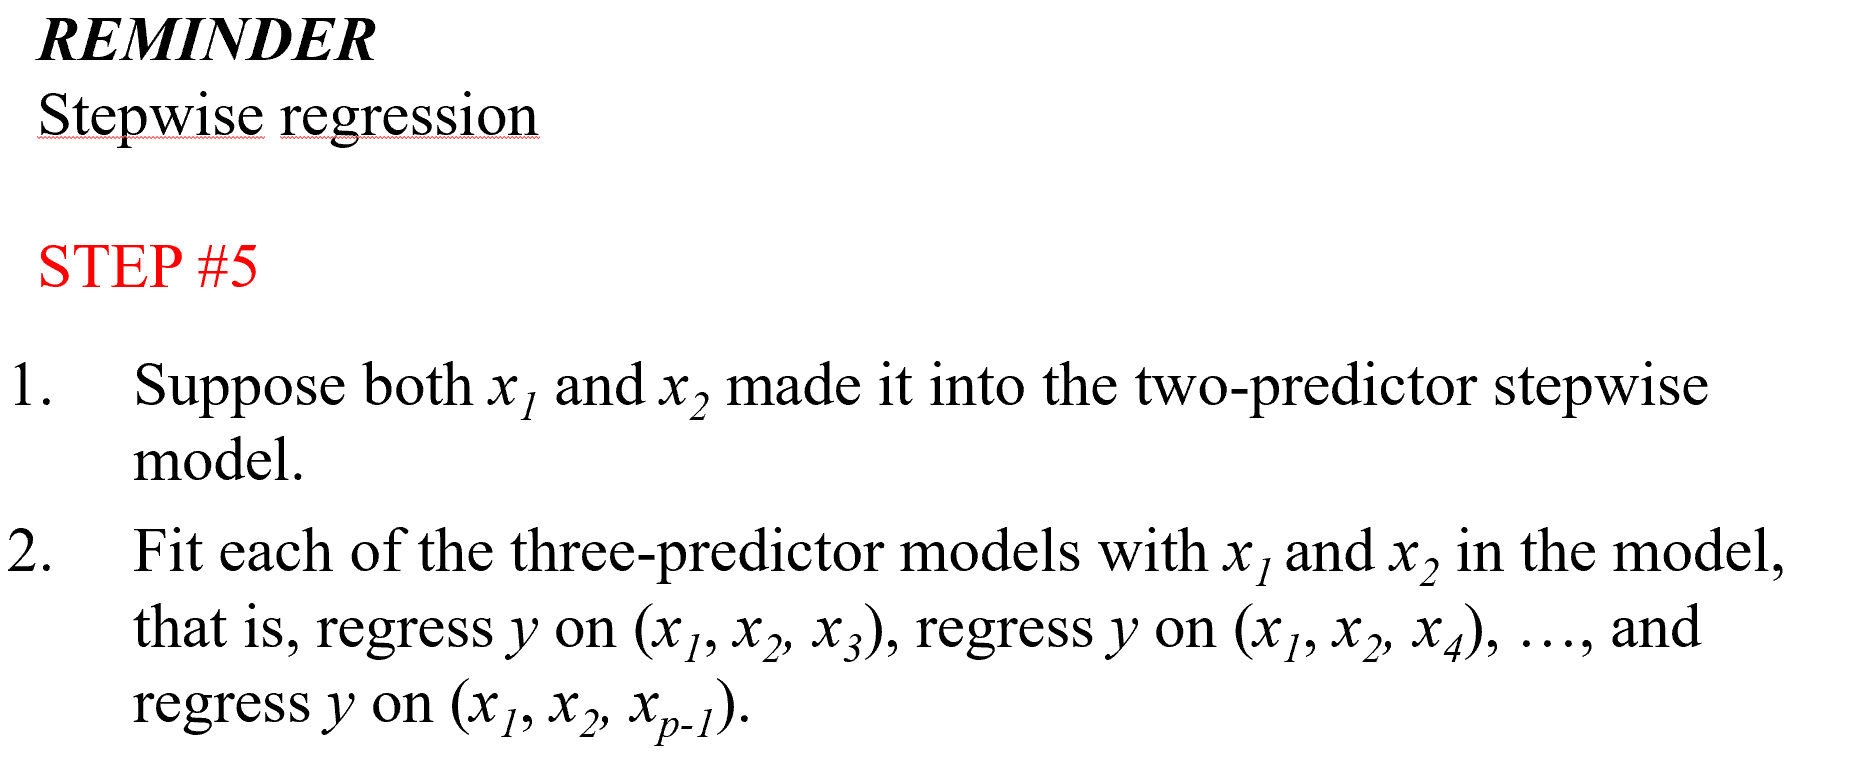
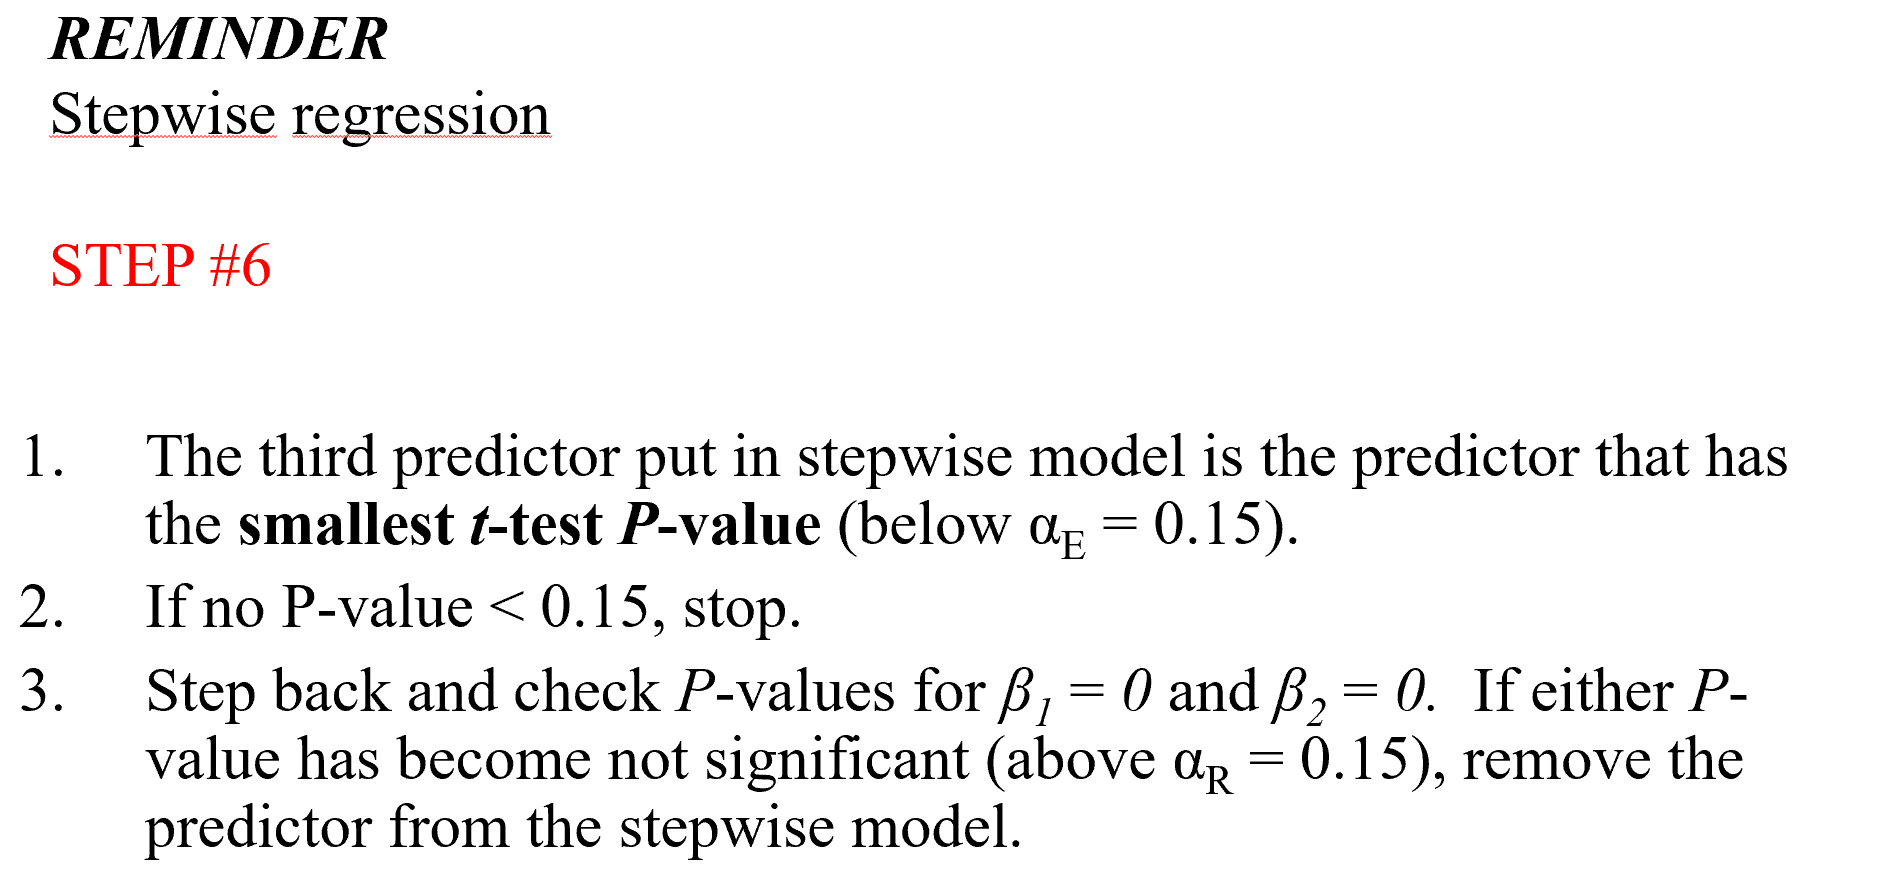
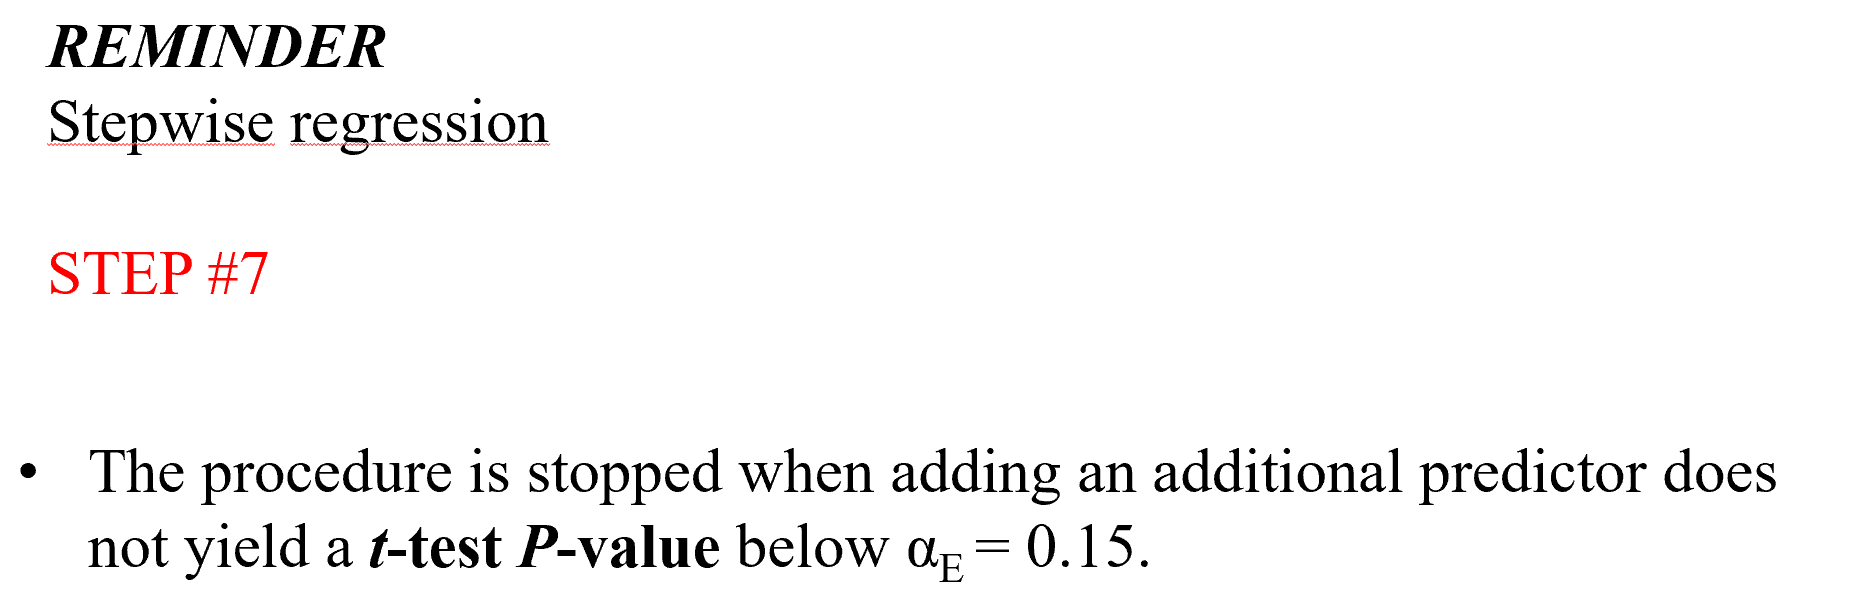



> Prepare the variables for the stepwise regression.

In [27]:
# Add a column to the dataset with the lagged values
data['Ex5_lag1'] = data['Ex5'].shift(1)

# and split the dataset into regressors and target
X = data.iloc[1:, 1:3]
y = data.iloc[1:, 0]


> Use the `StepwiseRegression` class built-in the `qda` library to perform the stepwise regression.

In [28]:
# Create a StepwiseRegression object using the qda library
import qda
stepwise = qda.StepwiseRegression(add_constant = True, direction = 'both', alpha_to_enter = 0.15, alpha_to_remove = 0.15)

# Fit the model
model = stepwise.fit(y, X)

Stepwise Regression

######################################
### Step 1
-------------------
Forward Selection

COEFFICIENTS
------------
    Term    Coef    P-Value
   const -0.0070 5.7212e-01
Ex5_lag1  0.8692 8.5655e-27

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
0.1089 0.7031        0.7

######################################
### Step 2
-------------------
Forward Selection

COEFFICIENTS
------------
    Term    Coef    P-Value
   const -5.6130 6.1671e-06
Ex5_lag1  0.5325 2.6109e-08
    year  0.0029 6.3119e-06

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
0.0982 0.7613     0.7562
-------------------
Backward Elimination

No predictor removed.

######################################
### Step 3
-------------------
Forward Selection
All predictors have been included in the model. Exiting stepwise.
-------------------


> Print out the summary of the stepwise regression.

In [29]:
results = model.model_fit
qda.summary(results)

REGRESSION EQUATION
-------------------
Ex5 =  -5.613 const + 0.532 Ex5_lag1 + 0.003 year

COEFFICIENTS
------------
    Term    Coef  SE Coef  T-Value    P-Value
   const -5.6130   1.1714  -4.7917 6.1671e-06
Ex5_lag1  0.5325   0.0876   6.0758 2.6109e-08
    year  0.0029   0.0006   4.7859 6.3119e-06

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
0.0982 0.7613     0.7562

ANALYSIS OF VARIANCE
---------------------
    Source   DF  Adj SS  Adj MS  F-Value    P-Value
Regression  2.0  2.8915  1.4458 149.9019 5.7392e-30
     const  1.0  0.2214  0.2214  22.9602 6.1671e-06
  Ex5_lag1  1.0  0.3560  0.3560  36.9149 2.6109e-08
      year  1.0  0.2209  0.2209  22.9046 6.3119e-06
     Error 94.0  0.9066  0.0096      NaN        NaN
     Total 96.0  3.7981     NaN      NaN        NaN


> Finally, let's check assumptions on the residuals.

Shapiro-Wilk test p-value = 0.654


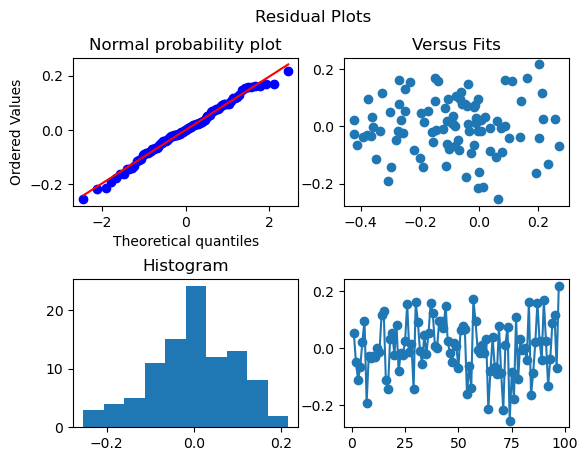

In [30]:
#Check on residuals
residuals = results.resid
fits = results.fittedvalues

# Perform the Shapiro-Wilk test
_, pval_SW = stats.shapiro(residuals)
print('Shapiro-Wilk test p-value = %.3f' % pval_SW)

# Plot the residuals
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(residuals, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(fits, residuals)
axs[0,1].set_title('Versus Fits')
fig.subplots_adjust(hspace=0.5)
axs[1,0].hist(residuals)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(residuals)+1), residuals, 'o-')
plt.show()

Runs test p-value on the residuals = 0.759


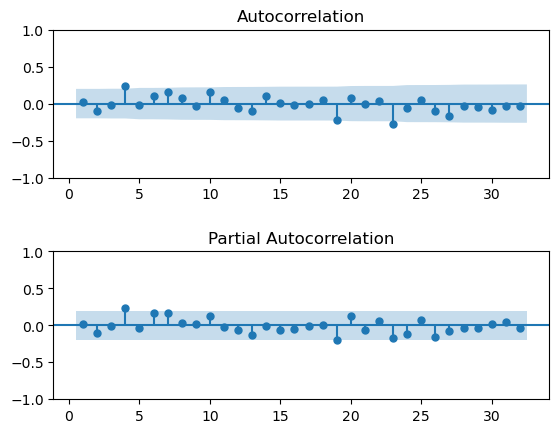

In [31]:
#RANDOMNESS OF FESIDUALS
_, pval_runs_res = runstest_1samp(residuals, correction=False)
print('Runs test p-value on the residuals = {:.3f}'.format(pval_runs_res))
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(residuals, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(residuals, lags = int(len(data)/3), zero=False, ax=ax[1], 
            method = 'ywm')
plt.show()

> The data are normal and random. But it looks like there's something strange at lag 4. 
> 
> Perform the Bartlett test at lag 4. Remember, 1 row was not used in the model, so $n = 98-1$.:
> $$| r_4 | > \frac{z_{\alpha/2}}{\sqrt{n}} = \frac{1.96}{\sqrt{97}} = 0.199$$

In [32]:
# get the value of the autocorrelation function at lag 4
acf4 = sgt.acf(residuals, nlags=4, fft=False)[4]
print('The value of the autocorrelation function at lag 4 is {:.3f}'.format(acf4))

The value of the autocorrelation function at lag 4 is 0.240


> Try adding a lag 4 term to the model and perform model selection again. 

In [33]:
# Add a lag4 term to the dataframe
data['Ex5_lag4'] = data['Ex5'].shift(4)

In [34]:
# Select the features and target
X = data.iloc[4:, 1:]
y = data.iloc[4:, 0]

# Fit the model
stepwise_2 = qda.StepwiseRegression(add_constant = True, direction = 'both', alpha_to_enter = 0.15, alpha_to_remove = 0.15)
model_2 = stepwise_2.fit(y,X)

Stepwise Regression

######################################
### Step 1
-------------------
Forward Selection

COEFFICIENTS
------------
    Term    Coef    P-Value
   const -0.0045 7.1609e-01
Ex5_lag1  0.8524 6.5369e-26

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
0.1078 0.7019     0.6986

######################################
### Step 2
-------------------
Forward Selection

COEFFICIENTS
------------
    Term    Coef    P-Value
   const -5.4632 3.9980e-05
Ex5_lag1  0.5327 7.7815e-08
    year  0.0028 4.0494e-05

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
0.0988 0.7525     0.7471
-------------------
Backward Elimination

No predictor removed.

######################################
### Step 3
-------------------
Forward Selection

COEFFICIENTS
------------
    Term    Coef    P-Value
   const -3.7043 1.1924e-02
Ex5_lag1  0.4962 3.5963e-07
    year  0.0019 1.1686e-02
Ex5_lag4  0.2089 2.0787e-02

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
0.0964 0.7669     0.

> Print out the summary of the stepwise regression.

In [35]:
results_2 = model_2.model_fit
qda.summary(results_2)

REGRESSION EQUATION
-------------------
Ex5 =  -3.704 const + 0.496 Ex5_lag1 + 0.002 year + 0.209 Ex5_lag4

COEFFICIENTS
------------
    Term    Coef  SE Coef  T-Value    P-Value
   const -3.7043   1.4433  -2.5665 1.1924e-02
Ex5_lag1  0.4962   0.0903   5.4954 3.5963e-07
    year  0.0019   0.0007   2.5740 1.1686e-02
Ex5_lag4  0.2089   0.0888   2.3533 2.0787e-02

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
0.0964 0.7669     0.7591

ANALYSIS OF VARIANCE
---------------------
    Source   DF  Adj SS  Adj MS  F-Value    P-Value
Regression  3.0  2.7525  0.9175  98.6812 2.3373e-28
     const  1.0  0.0612  0.0612   6.5870 1.1924e-02
  Ex5_lag1  1.0  0.2808  0.2808  30.1989 3.5963e-07
      year  1.0  0.0616  0.0616   6.6256 1.1686e-02
  Ex5_lag4  1.0  0.0515  0.0515   5.5379 2.0787e-02
     Error 90.0  0.8368  0.0093      NaN        NaN
     Total 93.0  3.5893     NaN      NaN        NaN


> Let's check again the residuals

Shapiro-Wilk test p-value = 0.725


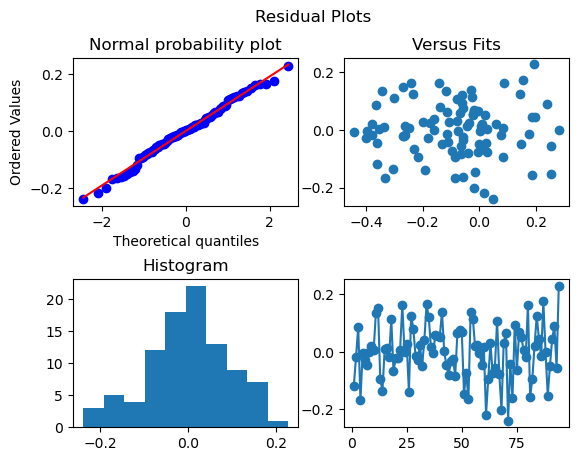

In [36]:
#Check on residuals
residuals = results_2.resid
fits = results_2.fittedvalues

# Perform the Shapiro-Wilk test
_, pval_SW = stats.shapiro(residuals)
print('Shapiro-Wilk test p-value = %.3f' % pval_SW)

# Plot the residuals
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(residuals, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(fits, residuals)
axs[0,1].set_title('Versus Fits')
fig.subplots_adjust(hspace=0.5)
axs[1,0].hist(residuals)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(residuals)+1), residuals, 'o-')
plt.show()

Runs test p-value on the residuals = 0.678


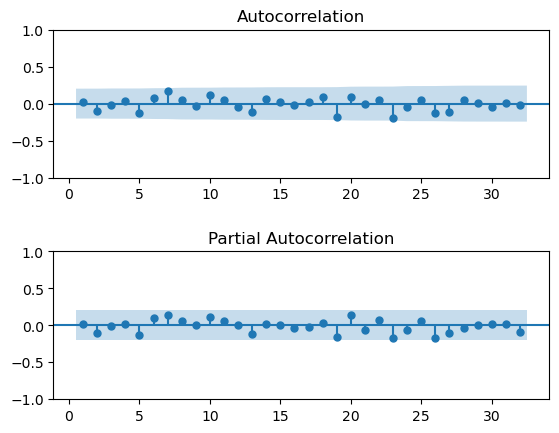

In [37]:
#RANDOMNESS OF FESIDUALS
_, pval_runs_res = runstest_1samp(residuals, correction=False)
print('Runs test p-value on the residuals = {:.3f}'.format(pval_runs_res))
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(residuals, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(residuals, lags = int(len(data)/3), zero=False, ax=ax[1], 
            method = 'ywm')
plt.show()

> The data are normal and random. If we compute $|r_4|$ again for the Bartlett test at lag 4:

In [38]:
# get the value of the autocorrelation function at lag 4
acf4 = sgt.acf(residuals, nlags=4, fft=False)[4]
print('The value of the autocorrelation function at lag 4 is {:.3f}'.format(acf4))

The value of the autocorrelation function at lag 4 is 0.033


> Remember, 4 rows were not used in the model, so $n = 98-4$.:
> $$| r_4 | > \frac{z_{\alpha/2}}{\sqrt{n}} = \frac{1.96}{\sqrt{94}} = 0.202$$
> $$| r_4 | = 0.033 < 0.202$$

> Now the autocorrelation at lag 4 is not significant. The assumptions ont he residuals are met, so we can accept the model.

## Point 2

Given the model, which is the global temperature of year 1998 (with probability 95%)?

> ### Solution
> We use the last model to predict the global temperature of year 1998. Let's create a dataframe with the values of the regressors. 

> Check the order of the predictors in the model

In [39]:
print(results_2.params)

const      -3.7043
Ex5_lag1    0.4962
year        0.0019
Ex5_lag4    0.2089
dtype: float64


> Create a new dataframe with the values of the regressors you want to evaluate the model on.
>
> **Remember**: the order of the predictors may not correspond to the one in the original dataframe.
>
> *Hint*: use the `iat[]` function to access a single scalar in a Pandas dataframe.

In [40]:
# Create a dataframe with the new predictors
data_predict = pd.DataFrame({'const': [1], 'Ex5_lag1': [data['Ex5'].iat[-1]], 'year': [1998], 'Ex5_lag4': [data['Ex5'].iat[-4]]})

In [41]:
#predict the next value
prediction = results_2.predict(data_predict)
print('The predicted value of Ex5 is %.3f.' % (prediction[0]))

The predicted value of Ex5 is 0.331.


In [42]:
# Compute the fit, confidence intervals and prediction intervals
prediction_summary = results_2.get_prediction(data_predict).summary_frame(alpha=0.05)
print(prediction_summary)

     mean  mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
0  0.3311   0.0296         0.2722         0.3899        0.1307        0.5315
